<a href="https://colab.research.google.com/github/konasivasaisubrahmanyam/projectml/blob/master/project_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Project Integration Work***

> ### **Mount the Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


 > ### **Change Directory**

In [ ]:
dir_path = '/content/gdrive/My Drive/Colab Notebooks/project work/'
%cd /content/gdrive/My Drive/Colab Notebooks/project work/
!ls -l

/content/gdrive/My Drive/Colab Notebooks/project work
total 1636939
drwx------ 2 root root       4096 Jul 28 08:08 '2020-07-28 08-08-30'
drwx------ 2 root root       4096 Jul 28 09:01 '2020-07-28 09-01-00'
drwx------ 2 root root       4096 Jul 28 12:32 '2020-07-28 12-32-46'
drwx------ 2 root root       4096 Jul 28 14:08 '2020-07-28 14-08-45'
-rw------- 1 root root   21589178 Jul 19  2019  2dtodepth_colab.zip
drwx------ 2 root root       4096 Jul 28 10:21 '3D Object'
drwx------ 2 root root       4096 Jul 28 14:18  MeshCNN-master
-rw------- 1 root root 1650377884 Jul 28 13:41 'MeshCNN-master old.zip'
-rw------- 1 root root    3715725 Jul 28 13:43  MeshCNN-master.zip
-rw------- 1 root root     213007 Jul 29 04:31 'project work.ipynb'
-rw------- 1 root root     290312 Jul 28 09:08 'project work without image.ipynb'
drwx------ 2 root root       4096 Jun 24 11:35  Resource
drwx------ 2 root root       4096 Jul 28 10:32  result
drwx------ 2 root root       4096 Jun 24 11:35 'trained model'


 > ### **Objection Detection**

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
tvmonitor 97.97921776771545
laptop 97.79006838798523


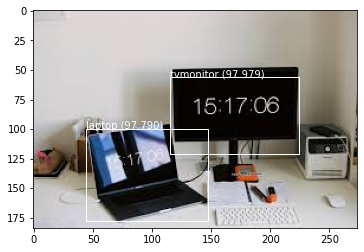

In [ ]:
import numpy as np
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness=None, classes=None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.score

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2] = _sigmoid(netout[..., :2])
    netout[..., 4:] = _sigmoid(netout[..., 4:])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h * grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if (objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w  # center position, unit: image width
            y = (row + y) / grid_h  # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w  # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h  # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x - w / 2, y - h / 2, x + w / 2, y + h / 2, objectness, classes)
            boxes.append(box)
    return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w) / 2. / net_w, float(new_w) / net_w
        y_offset, y_scale = (net_h - new_h) / 2. / net_h, float(new_h) / net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2, x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2, x4) - x3

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax - box1.xmin, box1.ymax - box1.ymin
    w2, h2 = box2.xmax - box2.xmin, box2.ymax - box2.ymin
    union = w1 * h1 + w2 * h2 - intersect
    return float(intersect) / union

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i + 1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i] * 100)
            # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    # show the plot
    pyplot.show()

# load yolov3 model
model = load_model(dir_path+'/trained model/model.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = dir_path+'/Resource/monitorlaptop.jpeg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])
# define the anchors
anchors = [[116, 90, 156, 198, 373, 326], [30, 61, 62, 45, 59, 119], [10, 13, 16, 30, 33, 23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)
# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
          "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
          "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
          "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
          "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
          "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
          "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
          "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
          "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

 > ### **Check the Input Video**

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(dir_path+'Resource/video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 autoplay muted loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

 > ### **Create Folder using Date and Time**

In [ ]:
import os,datetime

create = datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
main_folder = dir_path+create
os.mkdir(main_folder)
print('Folder Created path : '+main_folder)

Folder Created path : /content/gdrive/My Drive/Colab Notebooks/project work/2020-07-29 04-32-17


 > ### **AR Model Development using Predefined Dataset**

In [ ]:
import zipfile
with zipfile.ZipFile('MeshCNN-master.zip', "r") as z:
    # printing all the contents of the zip file 
    z.printdir()   
    # extracting all the files 
    print('Extracting all the files now...') 
    z.extractall(dir_path)
    print('Done!') 

os.chdir(dir_path+'MeshCNN-master/')
!ls -l
!bash ./scripts/human_seg/get_data.sh
!bash ./scripts/human_seg/train.sh
!bash ./scripts/human_seg/get_pretrained.sh
!bash ./scripts/human_seg/test.sh
!bash ./scripts/human_seg/view.sh

/content/gdrive/My Drive/Colab Notebooks/MeshCNN-master
total 54
drwx------ 3 root root 4096 Feb 12 01:20 checkpoints
drwx------ 3 root root 4096 Nov  7  2019 data
drwx------ 4 root root 4096 Jul 28 13:03 datasets
drwx------ 2 root root 4096 Nov  7  2019 docs
-rw------- 1 root root  244 Nov  7  2019 environment.yml
-rw------- 1 root root 1069 Nov  7  2019 LICENSE
drwx------ 2 root root 4096 Nov  7  2019 models
drwx------ 2 root root 4096 Nov  7  2019 options
drwx------ 2 root root 4096 Feb 11 07:28 __pycache__
-rw------- 1 root root 3656 Nov  7  2019 README.md
drwx------ 2 root root 4096 Feb 12 10:14 result_new
drwx------ 2 root root 4096 Feb 12 01:30 runs
drwx------ 3 root root 4096 Nov  7  2019 scripts
-rw------- 1 root root  656 Nov  7  2019 test.py
-rw------- 1 root root 2145 Nov  7  2019 train.py
drwx------ 2 root root 4096 Nov  7  2019 util
tensorboard X not installed, visualizing wont be available
------------ Options -------------
arch: mconvnet
batch_size: 16
beta1: 0.9
checkp

 > ### **Videos to frames**

In [ ]:
#import os,datetime
import cv2

path_frames = main_folder+'/frames extract'
os.mkdir(path_frames)
print('Folder Created path : '+path_frames)

#video to frames
vidcap = cv2.VideoCapture(dir_path+'Resource/video.mp4')
success,image = vidcap.read()
count = 1
success = True
while success:
    cv2.imwrite(path_frames+"/frame %d.jpg" % count, image)
    success,image = vidcap.read()
    print("Frame",count,"extracted")
    count += 1


Folder Created path : /content/gdrive/My Drive/Colab Notebooks/project work/2020-07-29 04-32-17/frames extract
Frame 1 extracted
Frame 2 extracted
Frame 3 extracted
Frame 4 extracted
Frame 5 extracted
Frame 6 extracted
Frame 7 extracted
Frame 8 extracted
Frame 9 extracted
Frame 10 extracted
Frame 11 extracted
Frame 12 extracted
Frame 13 extracted
Frame 14 extracted
Frame 15 extracted
Frame 16 extracted
Frame 17 extracted
Frame 18 extracted
Frame 19 extracted
Frame 20 extracted
Frame 21 extracted
Frame 22 extracted
Frame 23 extracted
Frame 24 extracted
Frame 25 extracted
Frame 26 extracted
Frame 27 extracted
Frame 28 extracted
Frame 29 extracted
Frame 30 extracted
Frame 31 extracted
Frame 32 extracted
Frame 33 extracted
Frame 34 extracted
Frame 35 extracted
Frame 36 extracted
Frame 37 extracted
Frame 38 extracted
Frame 39 extracted
Frame 40 extracted
Frame 41 extracted
Frame 42 extracted
Frame 43 extracted
Frame 44 extracted
Frame 45 extracted
Frame 46 extracted
Frame 47 extracted
Frame

> ### **Background subtraction**

In [ ]:
#@title **Background Subtraction**
option = "KNN" #@param ["MOG2", "KNN"]
from __future__ import print_function
import cv2 as cv
from google.colab.patches import cv2_imshow
import os
import glob
import matplotlib.pyplot as plt
import numpy as np

count = 0
if option == 'MOG2':
    print("working")
    backSub = cv.createBackgroundSubtractorMOG2()
else:
    backSub = cv.createBackgroundSubtractorKNN()
    
print("input",path_frames+'/frame %d.jpg')
capture = cv.VideoCapture(cv.samples.findFileOrKeep(path_frames+'/frame %d.jpg'))
if not capture.isOpened:
    print('Unable to open: ' + path_frames+'/frame %d.jpg')
    exit(0)
path_background = main_folder+'/Background Subtraction '+option
try:
    os.mkdir(path_background)
    print('Folder Created path : '+path_background)
except FileExistsError:
    print("Directory ---- ", path_background, " ---- already exists")
path = path_background+'/'   
while True:
    a=1
    ret, frame = capture.read()
    if frame is None:
        break
    fgMask = backSub.apply(frame)
    cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
    cv.putText(frame, str(capture.get(cv.CAP_PROP_POS_FRAMES)), (15, 15),cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
    count = count + 1
    image1 = cv2.resize(frame, (0, 0), None, .25, .25)
    image2 = cv2.resize(fgMask, (0, 0), None, .25, .25)
    print('Frame '+str(count))
    cv2_imshow(image1)
    print('FG Mask '+str(count))
    cv2_imshow(image2)
    print_file_name = 'sub frame '+str(count)+'.jpg'
    cv.imwrite(os.path.expanduser(os.path.join(path ,print_file_name)), fgMask)
    print('saved file name : '+print_file_name)
    a=a+1
    keyboard = cv.waitKey(30)
    if keyboard == 'q' or keyboard == 27:
        break

> ### **Feature Detection**

Folder Created path : /content/gdrive/My Drive/Colab Notebooks/project work/2020-07-29 04-32-17/Feature Detection


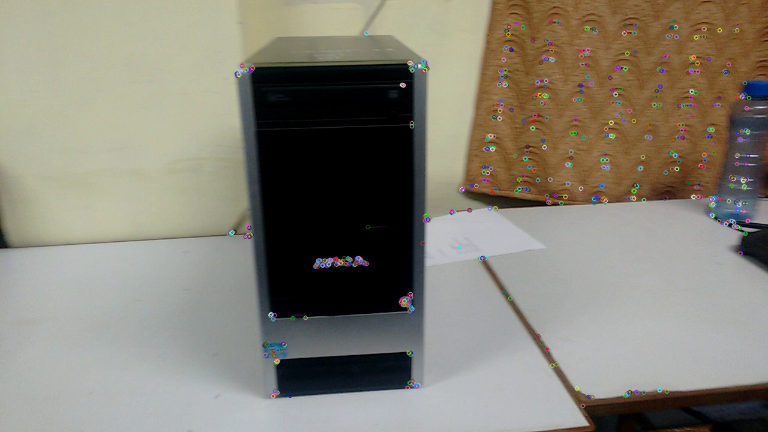

location path : /content/gdrive/My Drive/Colab Notebooks/project work/2020-07-29 04-32-17/Feature Detection/frame 1.jpg


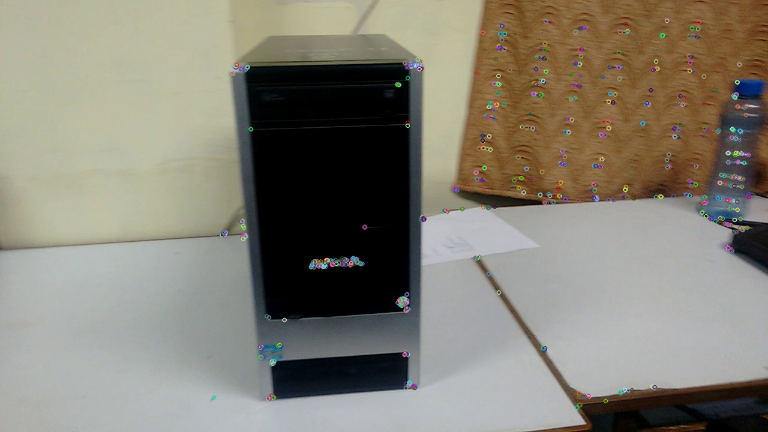

location path : /content/gdrive/My Drive/Colab Notebooks/project work/2020-07-29 04-32-17/Feature Detection/frame 2.jpg


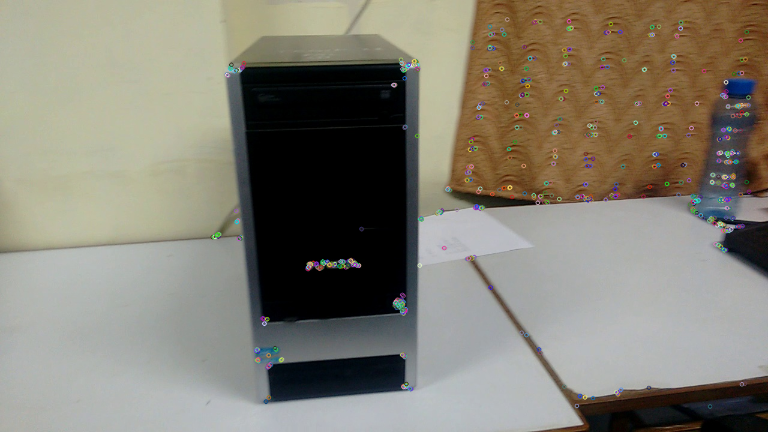

location path : /content/gdrive/My Drive/Colab Notebooks/project work/2020-07-29 04-32-17/Feature Detection/frame 3.jpg


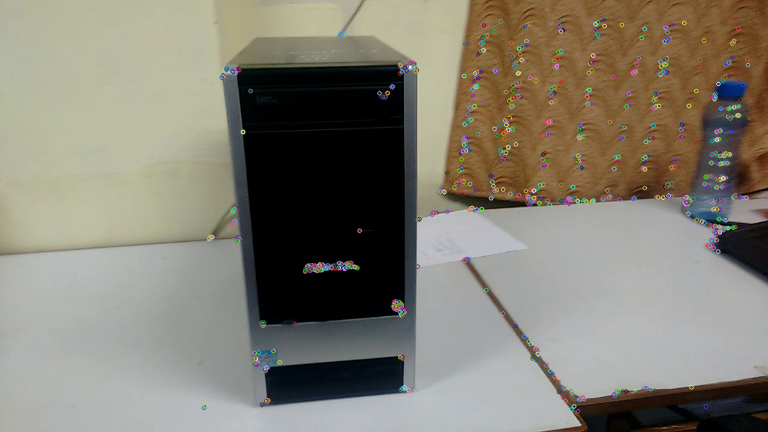

location path : /content/gdrive/My Drive/Colab Notebooks/project work/2020-07-29 04-32-17/Feature Detection/frame 4.jpg


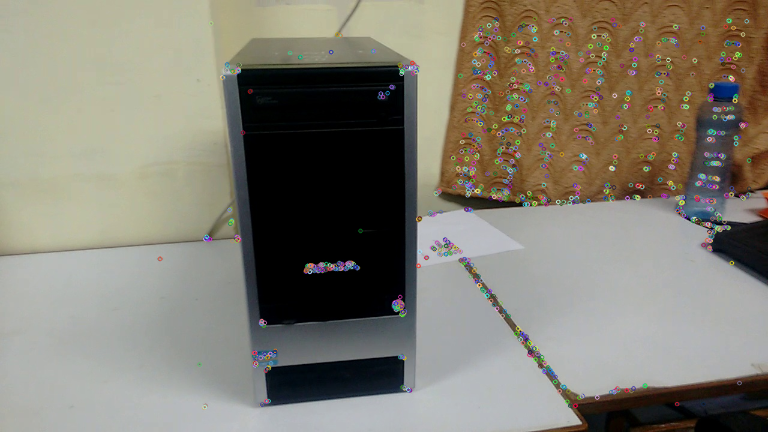

location path : /content/gdrive/My Drive/Colab Notebooks/project work/2020-07-29 04-32-17/Feature Detection/frame 5.jpg


In [ ]:
#import cv2

img_dir = path_frames+'/' # Enter Directory of all images
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
path_feature_detection = main_folder+'/Feature Detection'
try:
    os.mkdir(path_feature_detection)
    print('Folder Created path : '+path_feature_detection)
except FileExistsError:
    print("Directory ---- ", path_feature_detection, " ---- already exists")
for f1 in files:
    #print('running feature extract',f1)
    img = cv2.imread(f1)
    orb = cv2.ORB_create(nfeatures=10000)
    keypoints_orb1, descriptors = orb.detectAndCompute(img, None)
    img = cv2.drawKeypoints(img, keypoints_orb1, None)
    new_path = f1.replace('frames extract', 'Feature Detection')
    cv2.imwrite(new_path, img)
    image_ext = cv.resize(img, (0, 0), None, .50, .50)
    cv2_imshow(image_ext)
    print('location path : '+new_path)

> ### **Feature Matching**

In [ ]:
addpath = os.path.join(path_feature_detection+'/','*g')
feature_path = glob.glob(addpath)
path_feature_matching = main_folder+'/Feature Matching'
try:
    os.mkdir(path_feature_matching)
    print('Folder Created path : '+path_feature_matching)
except FileExistsError:
    print("Directory ---- ", path_feature_matching, " ---- already exists")
flag = 1
for count in range(0,len(feature_path),2):
    print('running feature matching', count)
    if count == len(feature_path)-1:
        feat_img1 = cv2.imread(feature_path[count])
        feat_img2 = cv2.imread(feature_path[random.randrange(0,len(feature_path))])
    else:
        feat_img1 = cv2.imread(feature_path[count])
        feat_img2 = cv2.imread(feature_path[count+1])
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(feat_img1,None)
    kp2, des2 = orb.detectAndCompute(feat_img2, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1,des2)
    matches = sorted(matches, key=lambda x: x.distance)
    feat_img = cv2.drawMatches(feat_img1, kp1, feat_img2, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    save_img = path_feature_matching+'/frame match '+str(flag)+'.png'
    print('saving the image', save_img)
    cv2.imwrite(save_img, feat_img)
    flag = flag+1
    image_feat = cv.resize(feat_img, (0, 0), None, .40, .40)
    cv2_imshow(image_feat)
    '''plt.tight_layout()
    plt.imshow(feat_img), plt.show()'''

> ### **2D to Depth**

In [ ]:
%cd /content/gdrive/My Drive/Colab Notebooks/project work/
!ls -l
print('------------------------------------------------------------------------------------------------------------------------------------------')

import zipfile

with zipfile.ZipFile('2dtodepth_colab.zip', "r") as z:
    # printing all the contents of the zip file 
    z.printdir()   
    # extracting all the files 
    print('Extracting all the files now...') 
    z.extractall(main_folder+'/')
    print('Done!') 
print('------------------------------------------------------------------------------------------------------------------------------------------')

os.chdir(main_folder+'/')
!ls -l
!rm 2dtodepth/infile/*
!rm 2dtodepth/outfile/* 
print('------------------------------------------------------------------------------------------------------------------------------------------')


import shutil  
source = path_frames+'/'
print(source)
destination = "2dtodepth/infile/"
print(destination)
#shutil.copyfile(source, destination) 
src_files = os.listdir(source)
for file_name in src_files:
    full_file_name = os.path.join(source, file_name)
    if os.path.isfile(full_file_name):
        # Copy the content of 
        # source to destination 
        try: 
            shutil.copy(full_file_name, destination) 
            print("File copied successfully : "+full_file_name) 
        # If source and destination are same 
        except shutil.SameFileError: 
            print("Source and destination represents the same file.") 
        # If destination is a directory. 
        except IsADirectoryError: 
            print("Destination is a directory.") 
        # If there is any permission issue 
        except PermissionError: 
            print("Permission denied.") 
        # For other errors 
        except: 
            print("Error occurred while copying file.") 

#!cp -av Resource/*.jpg 2dtodepth/infile
#!unzip 2dtodepth_colab.zip
%cd 2dtodepth
!ls -l

/content/gdrive/My Drive/Colab Notebooks/project work
total 1659964
drwx------  2 root root       4096 Jul 28 08:08 '2020-07-28 08-08-30'
drwx------  2 root root       4096 Jul 28 09:01 '2020-07-28 09-01-00'
drwx------  3 root root       4096 Jul 28 12:32 '2020-07-28 12-32-46'
drwx------  6 root root       4096 Jul 28 14:29 '2020-07-28 14-08-45'
-rw-------  1 root root   21589178 Jul 19  2019  2dtodepth_colab.zip
drwx------  2 root root       4096 Jul 28 10:21 '3D Object'
drwx------ 13 root root       4096 Jul 28 14:18  MeshCNN-master
-rw-------  1 root root 1650377884 Jul 28 13:41 'MeshCNN-master old.zip'
-rw-------  1 root root    3715725 Jul 28 13:43  MeshCNN-master.zip
-rw-------  1 root root   23791488 Jul 28 14:34 'project work.ipynb'
-rw-------  1 root root     290312 Jul 28 09:08 'project work without image.ipynb'
drwx------  2 root root       4096 Jun 24 11:35  Resource
drwx------  2 root root       4096 Jul 28 10:32  result
drwx------  2 root root       4096 Jun 24 11:35 'tra

In [ ]:
!python 2dtodepth.py --input=single_view
%cd -
!ls -l
outfile_path = main_folder+'/2dtodepth/outfile/'
src_files = os.listdir(outfile_path)
for file_name in src_files:
    full_file_name = os.path.join(outfile_path, file_name)
    if os.path.isfile(full_file_name):
        img = cv2.imread(full_file_name)
        image_2dtodepth = cv.resize(img, (0, 0), None, .40, .40)
        print(file_name)
        cv2_imshow(image_2dtodepth)

In [ ]:
#!python 2dtodepth.py --input=white

In [ ]:
#!python 2dtodepth.py --input=black

> ### **3D coordinates to create a point cloud**

In [ ]:
from __future__ import print_function
import cv2 as cv
from google.colab.patches import cv2_imshow
import os
import glob
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
from skimage.io import imread
im = imread(main_folder+'/2dtodepth/outfile/frame 150.jpg')
#im = cv.resize(img, (0, 0), None, .25, .25)
rows = im.shape
cols = im.shape
c, r = np.meshgrid(np.arange(cols), np.arange(rows), sparse=True)
valid = (im > 0) & (im < 255)
z = np.where(valid, im / 256.0, np.nan)
x = np.where(valid, z * c , 0)
y = np.where(valid, z * r , 0)
output = np.dstack((x, y, z))

#Storing the output in a file
a_file = open("test.txt", "w")
for row in output:
    np.savetxt(a_file, row)
a_file.close()

#Reading the file to create point cloud
a_file = open("test.txt", 'r')
point_cloud= np.loadtxt(a_file, skiprows=0, max_rows=1000000000)

#Plotting the graph
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
mean_Z=np.mean(point_cloud,axis=0)[2] 
spatial_query=point_cloud[abs( point_cloud[:,2]-mean_Z)<1]
xyz=spatial_query[:,:3]
rgb=spatial_query[:,3:]
ax = plt.axes(projection='3d')
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c = rgb/255, s=0.01)
plt.show()

TypeError: ignored